# Air Pollution forecasting for CDMX
_Authors: Ahumada, D. & Guerrero, J._

The following project 

In [ ]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import numpy as np

## Preparación de datos

### Fuentes de datos

In [ ]:
def print_head(src: str, n: int):
  res = requests.get(src)
  lines = res.text.splitlines()
  for i in range(n):
    print(lines[i])


In [ ]:
def id_parameters_to_cols(df: pd.DataFrame):
  cols = df['id_parameter'].unique()
  df = df.pivot_table('value', ['date', 'id_station'], 'id_parameter')
  df.reset_index( drop=False, inplace=True )
  df = df.reindex(['date', 'id_station'] + [ a for a in cols], axis=1)
  return df

#### Meteorología

In [ ]:
print_head("http://www.aire.cdmx.gob.mx/opendata/anuales_horarios/meteorología_2022.csv", 12)

Pollutants
city: Ciudad de M&eacute;xico
cityCode: MEX
country: M&eacute;xico
mesurementAgency: SIMAT
URL: http://www.aire.cdmx.gob.mx
timeStamp: 2022/01/01 al 2022/12/31
average_interval: 001h
version:DT001-IAD-20220518-142921
key: M-TUF48-M4TSI-DM8VN-LQIXE	
date,id_station,id_parameter,value,unit
01/01/2022 01:00,ACO,RH,71,6


In [ ]:
def fetch_db_meteorologia(anio: str):
  df = pd.read_csv(
      f"http://www.aire.cdmx.gob.mx/opendata/anuales_horarios/meteorolog%C3%ADa_{anio}.csv",
      encoding="latin1",
      skiprows=10
  )
  return df[df["id_parameter"] != "PBa"]

In [ ]:
df_meteorologia = fetch_db_meteorologia("2018")
for i in ["2019", "2020", "2021", "2022"]:
  df_meteorologia = df_meteorologia.append(fetch_db_meteorologia(i), ignore_index=True)

In [ ]:
df_meteorologia.tail()

,date,id_station,id_parameter,value,unit
4057243,30/04/2022 24:00,LAA,WSP,2.2,3
4057244,30/04/2022 24:00,FAR,WDR,313.0,4
4057245,30/04/2022 24:00,FAR,WSP,1.9,3
4057246,30/04/2022 24:00,SAC,WDR,NaN,4
4057247,30/04/2022 24:00,SAC,WSP,NaN,3


In [ ]:
df_meteorologia["date"].max()

'31/12/2021 24:00'

In [ ]:
df_meteorologia_h = id_parameters_to_cols(df_meteorologia)

In [ ]:
df_meteorologia_h.head()

id_parameter,date,id_station,RH,TMP,WDR,WSP
0,01/01/2018 01:00,ACO,52.0,11.3,25.0,2.5
1,01/01/2018 01:00,AJM,53.0,11.6,258.0,1.8
2,01/01/2018 01:00,AJU,91.0,2.2,194.0,1.9
3,01/01/2018 01:00,BJU,47.0,14.2,308.0,1.6
4,01/01/2018 01:00,CHO,59.0,10.2,157.0,0.5


#### Contaminantes

In [ ]:
print_head("http://www.aire.cdmx.gob.mx/opendata/anuales_horarios/contaminantes_2022.csv", 12)

Pollutants
city: Ciudad de M&eacute;xico
cityCode: MEX
country: M&eacute;xico
mesurementAgency: SIMAT
URL: http://www.aire.cdmx.gob.mx
timeStamp: 2022/01/01 al 2022/12/31
average_interval: 001h
version:DT001-IAD-20220518-142921
key: M-0TO1C-MV6D8-YWDJW-R1V7V	
date,id_station,id_parameter,value,unit
01/01/2022 01:00,ACO,CO,1.1,15


In [ ]:
def fetch_db_contaminantes(anio: str):
  return pd.read_csv(
      f"http://www.aire.cdmx.gob.mx/opendata/anuales_horarios/contaminantes_{anio}.csv",
      encoding="latin1",
      skiprows=10
  )

In [ ]:
df_contaminantes = fetch_db_contaminantes("2018")
for i in ["2019", "2020", "2021", "2022"]:
  df_contaminantes = df_contaminantes.append(fetch_db_contaminantes(i), ignore_index=True)

In [ ]:
df_contaminantes = id_parameters_to_cols(df_contaminantes)
df_contaminantes

id_parameter,date,id_station,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO
0,01/01/2018 01:00,ACO,0.4,3.0,23.0,25.0,8.0,125.0,2.0,NaN,NaN
1,01/01/2018 01:00,AJM,0.8,2.0,25.0,26.0,31.0,92.0,6.0,65.0,27.0
2,01/01/2018 01:00,AJU,NaN,NaN,NaN,NaN,17.0,NaN,NaN,49.0,NaN
3,01/01/2018 01:00,ATI,0.8,NaN,NaN,NaN,17.0,NaN,14.0,NaN,NaN
4,01/01/2018 01:00,BJU,0.6,NaN,NaN,NaN,22.0,78.0,9.0,56.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...
1052815,31/12/2021 24:00,CAM,1.7,53.0,53.0,107.0,1.0,36.0,1.0,28.0,8.0
1052816,31/12/2021 24:00,CHO,0.5,5.0,25.0,29.0,19.0,53.0,2.0,NaN,NaN
1052817,31/12/2021 24:00,IZT,1.2,14.0,51.0,65.0,5.0,79.0,3.0,NaN,NaN
1052818,31/12/2021 24:00,FAR,0.6,NaN,24.0,NaN,19.0,NaN,1.0,26.0,NaN


#### Estaciones

In [ ]:
print_head("http://www.aire.cdmx.gob.mx/opendata/catalogos/cat_estacion.csv", 12)

Catalogo de estaciones,,,,,,
cve_estac,nom_estac,longitud,latitud,alt,obs_estac,id_station
ACO,Acolman,-98.912003,19.635501,2198,,484150020109
AJU,Ajusco,-99.162611,19.154286,2942,,484090120400
AJM,Ajusco Medio,-99.207744,19.272161,2548,,484090120609
ARA,Aragón,-99.074549,19.470218,2200,Finalizó operación en 2010,484090050301
ATI,Atizapan,-99.254133,19.576963,2341,,484150130101
AZC,Azcapotzalco,-99.198657,19.487728,2279,Finalizó operación en 2010,484090020201
BJU,Benito Juárez,-99.159596,19.370464,2249,Finalizó operación en 2005,484090140201
CAM,Camarones,-99.169794,19.468404,2233,,484090020301
CCA,Centro de Ciencias de la Atmósfera,-99.176111,19.326111,2294,,484090030501
CES,Cerro de la Estrella,-99.074678,19.334731,2219,Finalizó operación en 2010,484090070111


In [ ]:
df_estaciones = pd.read_csv(
    "http://www.aire.cdmx.gob.mx/opendata/catalogos/cat_estacion.csv",
     encoding="latin1",
    skiprows=1
)

In [ ]:
df_estaciones

,cve_estac,nom_estac,longitud,latitud,alt,obs_estac,id_station
0,ACO,Acolman,-98.912003,19.635501,2198.0,NaN,484150020109
1,AJU,Ajusco,-99.162611,19.154286,2942.0,NaN,484090120400
2,AJM,Ajusco Medio,-99.207744,19.272161,2548.0,NaN,484090120609
3,ARA,Aragón,-99.074549,19.470218,2200.0,Finalizó operación en 2010,484090050301
4,ATI,Atizapan,-99.254133,19.576963,2341.0,NaN,484150130101
...,...,...,...,...,...,...,...
64,VIF,Villa de las Flores,-99.096590,19.658223,2242.0,NaN,484150200109
65,XAL,Xalostoc,-99.082400,19.525995,2160.0,NaN,484150330415
66,XCH,Xochimilco,-99.118252,19.267066,2243.0,Finalizó operación en 1999,484090130102
67,FAR,FES Aragón,-99.046176,19.473692,2230.0,NaN,484800150584


In [ ]:
df_aire = pd.merge(df_contaminantes, df_meteorologia_h, on=["id_station", "date"])
df_aire

id_parameter,date,id_station,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP
0,01/01/2018 01:00,ACO,0.4,3.0,23.0,25.0,8.0,125.0,2.0,NaN,NaN,52.0,11.3,25.0,2.5
1,01/01/2018 01:00,AJM,0.8,2.0,25.0,26.0,31.0,92.0,6.0,65.0,27.0,53.0,11.6,258.0,1.8
2,01/01/2018 01:00,AJU,NaN,NaN,NaN,NaN,17.0,NaN,NaN,49.0,NaN,91.0,2.2,194.0,1.9
3,01/01/2018 01:00,BJU,0.6,NaN,NaN,NaN,22.0,78.0,9.0,56.0,22.0,47.0,14.2,308.0,1.6
4,01/01/2018 01:00,CUA,0.5,4.0,31.0,34.0,16.0,137.0,11.0,NaN,NaN,56.0,10.6,340.0,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807223,31/12/2021 24:00,UIZ,0.7,7.0,39.0,45.0,14.0,74.0,2.0,44.0,30.0,54.0,15.5,186.0,1.2
807224,31/12/2021 24:00,VIF,2.5,69.0,55.0,124.0,2.0,110.0,5.0,NaN,NaN,50.0,14.5,177.0,0.9
807225,31/12/2021 24:00,CHO,0.5,5.0,25.0,29.0,19.0,53.0,2.0,NaN,NaN,53.0,13.5,149.0,1.1
807226,31/12/2021 24:00,FAR,0.6,NaN,24.0,NaN,19.0,NaN,1.0,26.0,NaN,NaN,NaN,77.0,1.1


In [ ]:
df_aire = pd.merge(
    df_estaciones[["cve_estac", "nom_estac", "longitud", "latitud"]],
    df_aire,
    left_on="cve_estac",
    right_on="id_station",
    how='inner'
)

In [ ]:
df_aire

,cve_estac,nom_estac,longitud,latitud,date,id_station,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP
0,ACO,Acolman,-98.912003,19.635501,01/01/2018 01:00,ACO,0.4,3.0,23.0,25.0,8.0,125.0,2.0,NaN,NaN,52.0,11.3,25.0,2.5
1,ACO,Acolman,-98.912003,19.635501,01/01/2018 02:00,ACO,0.4,2.0,19.0,21.0,13.0,98.0,3.0,NaN,NaN,52.0,10.6,359.0,1.7
2,ACO,Acolman,-98.912003,19.635501,01/01/2018 03:00,ACO,0.4,2.0,15.0,17.0,15.0,88.0,3.0,NaN,NaN,53.0,9.9,347.0,2.5
3,ACO,Acolman,-98.912003,19.635501,01/01/2018 04:00,ACO,0.4,2.0,14.0,15.0,20.0,82.0,3.0,NaN,NaN,53.0,9.4,330.0,2.7
4,ACO,Acolman,-98.912003,19.635501,01/01/2018 05:00,ACO,0.4,2.0,14.0,16.0,16.0,96.0,4.0,NaN,NaN,60.0,7.5,319.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807223,SAC,Santiago Acahualtepec,-99.009381,19.345610,31/12/2021 20:00,SAC,0.8,2.0,22.0,24.0,30.0,NaN,NaN,43.0,NaN,NaN,NaN,139.0,4.5
807224,SAC,Santiago Acahualtepec,-99.009381,19.345610,31/12/2021 21:00,SAC,0.8,1.0,19.0,21.0,28.0,NaN,NaN,35.0,NaN,NaN,NaN,125.0,4.8
807225,SAC,Santiago Acahualtepec,-99.009381,19.345610,31/12/2021 22:00,SAC,0.8,2.0,23.0,24.0,23.0,NaN,NaN,39.0,NaN,NaN,NaN,123.0,4.6
807226,SAC,Santiago Acahualtepec,-99.009381,19.345610,31/12/2021 23:00,SAC,0.6,1.0,19.0,20.0,25.0,NaN,NaN,32.0,NaN,NaN,NaN,127.0,4.6


In [ ]:
df_aire.to_csv("df_aire.csv")

In [ ]:
!ls

df_aire.csv  sample_data


#### Mapas de México

In [ ]:
!pip install geopandas
!pip uninstall rtree -y
!sudo apt install libspatialindex-dev
!pip install rtree

     |████████████████████████████████| 1.0 MB 4.4 MB/s 
     |████████████████████████████████| 6.3 MB 46.0 MB/s 
     |████████████████████████████████| 16.7 MB 47.7 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http:/

In [ ]:
import geopandas as gpd

In [ ]:
!wget "http://jjsantoso.com/blog/datos/mapa_mexico.zip"
!unzip mapa_mexico.zip

--2022-05-23 01:28:03--  http://jjsantoso.com/blog/datos/mapa_mexico.zip
Resolving jjsantoso.com (jjsantoso.com)... 52.219.99.0
Connecting to jjsantoso.com (jjsantoso.com)|52.219.99.0|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11337915 (11M) [application/zip]
Saving to: ‘mapa_mexico.zip’

mapa_mexico.zip     100%[===================>]  10.81M  5.92MB/s    in 1.8s    

2022-05-23 01:28:05 (5.92 MB/s) - ‘mapa_mexico.zip’ saved [11337915/11337915]

Archive:  mapa_mexico.zip
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.dbf  
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.prj  
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.sbn  
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.sbx  
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.shp  
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.shp.xml  
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.shx  


In [ ]:
gdf_mx = gpd.read_file('mapa_mexico/')

In [ ]:
gdf_mx.drop_duplicates(subset = ["CVE_EDO"])

,CLAVE,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry
0,02004,Tijuana,Baja California,02,004,1122.661145,"POLYGON ((-117.09481 32.41141, -117.09481 32.4..."
4,26055,San Luis Rio Colorado,Sonora,26,055,9033.770278,"POLYGON ((-114.96166 32.36465, -114.96239 32.3..."
10,08005,Ascension,Chihuahua,08,005,12980.720491,"POLYGON ((-108.20803 31.33335, -108.20804 31.4..."
66,05002,Acuña,Coahuila,05,002,11493.631607,"POLYGON ((-102.28642 29.87223, -102.28515 29.8..."
112,03002,Mulege,Baja California Sur,03,002,31772.313354,"POLYGON ((-112.76431 28.00001, -112.76177 27.9..."
138,19005,Anahuac,Nuevo Leon,19,005,4514.176154,"POLYGON ((-99.83317 27.76236, -99.83024 27.762..."
145,28027,Nuevo Laredo,Tamaulipas,28,027,1212.778180,"POLYGON ((-99.72785 27.67892, -99.72543 27.675..."
165,25007,Choix,Sinaloa,25,007,3185.953784,"POLYGON ((-108.30306 27.03613, -108.30281 27.0..."
180,10017,Ocampo,Durango,10,017,3597.863507,"POLYGON ((-105.97007 26.79002, -105.96991 26.7..."
279,32027,Melchor Ocampo,Zacatecas,32,027,1952.458047,"POLYGON ((-102.45856 25.11611, -102.45802 25.1..."


In [ ]:
gdf_cdmx = gdf_mx[gdf_mx["CVE_EDO"] == "09"]

In [ ]:
gdf_cdmx

,CLAVE,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry
1162,09005,Gustavo A. Madero,D.F.,09,005,87.445402,"POLYGON ((-99.11705 19.58909, -99.11748 19.588..."
1195,09002,Azcapotzalco,D.F.,09,002,33.420781,"POLYGON ((-99.15688 19.50231, -99.15684 19.502..."
1214,09016,Miguel Hidalgo,D.F.,09,016,45.938498,"POLYGON ((-99.20666 19.47052, -99.20610 19.470..."
1218,09015,Cuauhtemoc,D.F.,09,015,32.383814,"POLYGON ((-99.14274 19.46446, -99.14243 19.464..."
1223,09017,Venustiano Carranza,D.F.,09,017,33.599971,"POLYGON ((-99.05068 19.44927, -99.04696 19.440..."
1244,09006,Iztacalco,D.F.,09,006,23.123819,"POLYGON ((-99.12534 19.40359, -99.12184 19.404..."
1251,09014,Benito Juarez,D.F.,09,014,26.400780,"POLYGON ((-99.13543 19.40262, -99.13557 19.402..."
1252,09010,Alvaro Obregon,D.F.,09,010,95.434621,"POLYGON ((-99.24694 19.38558, -99.24584 19.386..."
1253,09004,Cuajimalpa de Morelos,D.F.,09,004,70.047016,"POLYGON ((-99.25510 19.40213, -99.25499 19.401..."
1254,09007,Iztapalapa,D.F.,09,007,113.106540,"POLYGON ((-99.05769 19.39993, -99.03938 19.391..."


In [ ]:
df_temp = df_aire.drop_duplicates(subset = ["id_station"])
df_temp = df_temp[["cve_estac", "nom_estac",	"longitud", "latitud", "id_station"]]
gdf_estaciones = gpd.GeoDataFrame(df_temp, geometry=gpd.points_from_xy(df_temp.longitud, df_temp.latitud))
gdf_estaciones.head(2)

,cve_estac,nom_estac,longitud,latitud,id_station,geometry
0,ACO,Acolman,-98.912003,19.635501,ACO,POINT (-98.91200 19.63550)
25988,AJU,Ajusco,-99.162611,19.154286,AJU,POINT (-99.16261 19.15429)


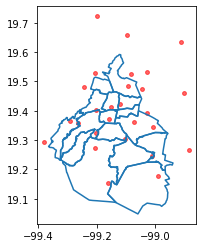

In [ ]:
ax =gdf_cdmx.boundary.plot()
gdf_estaciones.plot(ax=ax, color='red',markersize=15, alpha=0.6)

In [ ]:
gdf_cdmx_con_estacion = gdf_cdmx.sjoin(gdf_estaciones, how="inner")

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [ ]:
gdf_cdmx_con_estacion

,CLAVE,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry,index_right,cve_estac,nom_estac,longitud,latitud,id_station
1162,09005,Gustavo A. Madero,D.F.,09,005,87.445402,"POLYGON ((-99.11705 19.58909, -99.11748 19.588...",221978,GAM,Gustavo A. Madero,-99.094517,19.482700,GAM
1214,09016,Miguel Hidalgo,D.F.,09,016,45.938498,"POLYGON ((-99.20666 19.47052, -99.20610 19.470...",342516,MGH,Miguel Hidalgo,-99.202660,19.404050,MGH
1218,09015,Cuauhtemoc,D.F.,09,015,32.383814,"POLYGON ((-99.14274 19.46446, -99.14243 19.464...",257084,HGM,Hospital General de México,-99.152207,19.411617,HGM
1223,09017,Venustiano Carranza,D.F.,09,017,33.599971,"POLYGON ((-99.05068 19.44927, -99.04696 19.440...",305374,MER,Merced,-99.119594,19.424610,MER
1251,09014,Benito Juarez,D.F.,09,014,26.400780,"POLYGON ((-99.13543 19.40262, -99.13557 19.402...",69867,BJU,Benito Juárez,-99.159596,19.370464,BJU
1252,09010,Alvaro Obregon,D.F.,09,010,95.434621,"POLYGON ((-99.24694 19.38558, -99.24584 19.386...",475171,PED,Pedregal,-99.204136,19.325146,PED
1253,09004,Cuajimalpa de Morelos,D.F.,09,004,70.047016,"POLYGON ((-99.25510 19.40213, -99.25499 19.401...",123233,CUA,Cuajimalpa,-99.291705,19.365313,CUA
1253,09004,Cuajimalpa de Morelos,D.F.,09,004,70.047016,"POLYGON ((-99.25510 19.40213, -99.25499 19.401...",542712,SFE,Santa FE,-99.262865,19.357357,SFE
1254,09007,Iztapalapa,D.F.,09,007,113.106540,"POLYGON ((-99.05769 19.39993, -99.03938 19.391...",678095,UIZ,UAM Iztapalapa,-99.073880,19.360794,UIZ
1254,09007,Iztapalapa,D.F.,09,007,113.106540,"POLYGON ((-99.05769 19.39993, -99.03938 19.391...",781609,SAC,Santiago Acahualtepec,-99.009381,19.345610,SAC


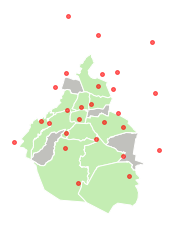

In [ ]:
ax = gdf_cdmx.plot(color='#c1c1bd', edgecolor='white')
ax.axis('off')
gdf_cdmx_con_estacion.plot(ax=ax, color="#c4edb3", edgecolor='white')
gdf_estaciones.plot(ax=ax, color='red',markersize=15, alpha=0.6)

In [ ]:
#gdf_cdmx_con_estacion_pol.columns

In [ ]:
#gdf_cdmx_con_estacion_pol = gdf_cdmx_con_estacion_pol.groupby("CVE_MUNI").mean().reset_index()

In [ ]:
#gdf_cdmx_con_estacion_pol = pd.merge(gdf_cdmx_con_estacion_pol, gdf_cdmx_con_estacion, on="CVE_MUNI", how='inner')

In [ ]:
#gdf_cdmx_con_estacion_pol["PM2.5"].min()

In [ ]:
#gdf_cdmx_con_estacion_pol = gpd.GeoDataFrame(gdf_cdmx_con_estacion_pol)

In [ ]:
#gdf_cdmx_con_estacion_pol

In [ ]:
#ax = gdf_cdmx.plot(color='#c0c0c0', edgecolor='white', figsize=(10, 10))
#ax.axis('off')
#ax.set_title("PM10 por Alcaldía")
#gdf_cdmx_con_estacion_pol.plot(ax=ax, column='TMP', cmap='YlOrRd', edgecolor='white', legend=True)
#gdf_estaciones.plot(ax=ax, color='red',markersize=15, alpha=0.6, figsize=(80, 40))

In [ ]:
#gdf_cdmx_con_estacion.shape[0]

### Valores Nulos

In [ ]:
def create_df_nan(df: pd.DataFrame, grouping_col: str = "id_station"):
  df_nan = df.copy()
  df_nan["__aux"] = df_nan[grouping_col]
  df_nan = df_nan.groupby(grouping_col).count() #Cuenta cantidad de lecturas no nulos por estación
  cols = df_nan.select_dtypes(include=np.number).columns.tolist()
  df_nan[cols] = df_nan[cols].div(df_nan["__aux"], axis=0)
  df_nan = 1 - df_nan
  df_nan["avg"] = df_nan.sum(axis=1) / (len(df_nan.columns) - 5)
  print(df.isna().sum().sum())
  print(df_nan["avg"].sum())
  return df_nan

In [ ]:
create_df_nan(df_aire)

2434976
5.847386462296716


,cve_estac,nom_estac,longitud,latitud,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,__aux,avg
id_station,,,,,,,,,,,,,,,,,,,,
ACO,0.0,0.0,0.0,0.0,0.0,0.274396,0.278205,0.278244,0.278167,0.229029,0.072226,0.327151,1.000000,1.000000,0.241265,0.016700,0.027128,0.027128,0.0,0.289260
AJM,0.0,0.0,0.0,0.0,0.0,0.026366,0.046909,0.046909,0.046909,0.152750,0.235823,0.044495,0.235823,0.235823,0.093297,0.122882,0.000189,0.000189,0.0,0.092026
AJU,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.067244,1.000000,1.000000,0.306333,1.000000,0.451765,0.129785,0.050938,0.050938,0.0,0.575500
BJU,0.0,0.0,0.0,0.0,0.0,0.028395,1.000000,0.295987,1.000000,0.044944,0.143345,0.133684,0.143345,0.143345,0.004228,0.062138,0.000000,0.000000,0.0,0.214244
CHO,0.0,0.0,0.0,0.0,0.0,0.128009,0.162334,0.162334,0.162334,0.042764,0.151345,0.168338,1.000000,1.000000,0.109034,0.109091,0.000113,0.000113,0.0,0.228272
CUA,0.0,0.0,0.0,0.0,0.0,0.061985,0.126611,0.126611,0.126611,0.049269,0.191029,0.077586,1.000000,1.000000,0.038984,0.033564,0.276467,0.276467,0.0,0.241799
CUT,0.0,0.0,0.0,0.0,0.0,1.000000,0.055320,0.055320,0.055320,0.049242,0.056577,0.053654,1.000000,1.000000,0.081095,0.085946,0.057161,0.057161,0.0,0.257628
FAC,0.0,0.0,0.0,0.0,0.0,0.062358,0.053546,0.053546,0.053546,0.044118,0.127179,0.105553,1.000000,1.000000,0.076822,0.076850,0.000196,0.000196,0.0,0.189565
FAR,0.0,0.0,0.0,0.0,0.0,0.246623,1.000000,0.064687,1.000000,0.115826,1.000000,0.066680,0.069081,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.468778


In [ ]:
df_aire.head()

,cve_estac,nom_estac,longitud,latitud,date,id_station,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP
0,ACO,Acolman,-98.912003,19.635501,01/01/2018 01:00,ACO,0.4,3.0,23.0,25.0,8.0,125.0,2.0,NaN,NaN,52.0,11.3,25.0,2.5
1,ACO,Acolman,-98.912003,19.635501,01/01/2018 02:00,ACO,0.4,2.0,19.0,21.0,13.0,98.0,3.0,NaN,NaN,52.0,10.6,359.0,1.7
2,ACO,Acolman,-98.912003,19.635501,01/01/2018 03:00,ACO,0.4,2.0,15.0,17.0,15.0,88.0,3.0,NaN,NaN,53.0,9.9,347.0,2.5
3,ACO,Acolman,-98.912003,19.635501,01/01/2018 04:00,ACO,0.4,2.0,14.0,15.0,20.0,82.0,3.0,NaN,NaN,53.0,9.4,330.0,2.7
4,ACO,Acolman,-98.912003,19.635501,01/01/2018 05:00,ACO,0.4,2.0,14.0,16.0,16.0,96.0,4.0,NaN,NaN,60.0,7.5,319.0,2.5


In [ ]:
def parse_date(x: str, format: str='%d/%m/%Y %H:%M'):
  has_24 = x.endswith("24:00")
  if has_24:
    x = x.replace("24:00", "00:00")
  dt = datetime.strptime(x, format)
  if has_24:
    dt = dt + timedelta(days=1)  
  return dt

parse_date("01/01/2022 24:00")

datetime.datetime(2022, 1, 2, 0, 0)

In [ ]:
df_aire["date"] = df_aire["date"].apply(parse_date)

In [ ]:
df_aire_time = df_aire.sort_values(by=["cve_estac", "date"])
df_aire_time = df_aire_time.groupby(by="cve_estac", as_index=False).fillna(method="ffill", limit=12)

In [ ]:
df_aire_time

,nom_estac,longitud,latitud,date,id_station,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP
0,Acolman,-98.912003,19.635501,2018-01-01 01:00:00,ACO,0.4,3.0,23.0,25.0,8.0,125.0,2.0,NaN,NaN,52.0,11.3,25.0,2.5
1,Acolman,-98.912003,19.635501,2018-01-01 02:00:00,ACO,0.4,2.0,19.0,21.0,13.0,98.0,3.0,NaN,NaN,52.0,10.6,359.0,1.7
2,Acolman,-98.912003,19.635501,2018-01-01 03:00:00,ACO,0.4,2.0,15.0,17.0,15.0,88.0,3.0,NaN,NaN,53.0,9.9,347.0,2.5
3,Acolman,-98.912003,19.635501,2018-01-01 04:00:00,ACO,0.4,2.0,14.0,15.0,20.0,82.0,3.0,NaN,NaN,53.0,9.4,330.0,2.7
4,Acolman,-98.912003,19.635501,2018-01-01 05:00:00,ACO,0.4,2.0,14.0,16.0,16.0,96.0,4.0,NaN,NaN,60.0,7.5,319.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757024,Xalostoc,-99.082400,19.525995,2019-12-31 20:00:00,XAL,0.7,4.0,30.0,34.0,23.0,NaN,6.0,NaN,NaN,41.0,19.1,28.0,3.6
757025,Xalostoc,-99.082400,19.525995,2019-12-31 21:00:00,XAL,0.6,5.0,29.0,33.0,18.0,NaN,6.0,NaN,NaN,48.0,17.5,28.0,3.4
757026,Xalostoc,-99.082400,19.525995,2019-12-31 22:00:00,XAL,0.9,15.0,38.0,53.0,8.0,NaN,6.0,NaN,NaN,49.0,17.0,1.0,1.6
757027,Xalostoc,-99.082400,19.525995,2019-12-31 23:00:00,XAL,0.9,8.0,40.0,49.0,8.0,NaN,6.0,NaN,NaN,52.0,16.5,30.0,1.5


In [ ]:
create_df_nan(df_aire_time)

2268616
5.867140189586729


,nom_estac,longitud,latitud,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,__aux,avg
id_station,,,,,,,,,,,,,,,,,,,
ACO,0.0,0.0,0.0,0.0,0.250346,0.253540,0.253540,0.253540,0.202709,0.062837,0.299946,1.000000,1.000000,0.240149,0.015700,0.026127,0.026127,0.0,0.298812
AJM,0.0,0.0,0.0,0.0,0.003929,0.021206,0.021206,0.021206,0.125864,0.219966,0.017561,0.219966,0.219966,0.091404,0.120894,0.000000,0.000000,0.0,0.083321
AJU,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.042632,1.000000,1.000000,0.262119,1.000000,0.450578,0.125742,0.049356,0.049356,0.0,0.613829
BJU,0.0,0.0,0.0,0.0,0.004900,1.000000,0.276861,1.000000,0.017194,0.125620,0.107586,0.125620,0.125620,0.003892,0.061466,0.000000,0.000000,0.0,0.219135
CHO,0.0,0.0,0.0,0.0,0.101954,0.130841,0.130841,0.130841,0.011158,0.115661,0.137865,1.000000,1.000000,0.107675,0.107675,0.000000,0.000000,0.0,0.228809
CUA,0.0,0.0,0.0,0.0,0.037455,0.100691,0.100691,0.100691,0.019179,0.162781,0.047914,1.000000,1.000000,0.036135,0.031305,0.275182,0.275182,0.0,0.245170
CUT,0.0,0.0,0.0,0.0,1.000000,0.023730,0.023730,0.023730,0.015459,0.015167,0.019463,1.000000,1.000000,0.079488,0.084222,0.057132,0.057132,0.0,0.261481
FAC,0.0,0.0,0.0,0.0,0.037348,0.024059,0.024059,0.024059,0.014799,0.076151,0.076962,1.000000,1.000000,0.076151,0.076151,0.000000,0.000000,0.0,0.186903
FAR,0.0,0.0,0.0,0.0,0.224898,1.000000,0.034296,1.000000,0.084540,1.000000,0.034540,0.043409,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.493976


In [ ]:
df_aire_time.head()

,nom_estac,longitud,latitud,date,id_station,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP
0,Acolman,-98.912003,19.635501,2018-01-01 01:00:00,ACO,0.4,3.0,23.0,25.0,8.0,125.0,2.0,NaN,NaN,52.0,11.3,25.0,2.5
1,Acolman,-98.912003,19.635501,2018-01-01 02:00:00,ACO,0.4,2.0,19.0,21.0,13.0,98.0,3.0,NaN,NaN,52.0,10.6,359.0,1.7
2,Acolman,-98.912003,19.635501,2018-01-01 03:00:00,ACO,0.4,2.0,15.0,17.0,15.0,88.0,3.0,NaN,NaN,53.0,9.9,347.0,2.5
3,Acolman,-98.912003,19.635501,2018-01-01 04:00:00,ACO,0.4,2.0,14.0,15.0,20.0,82.0,3.0,NaN,NaN,53.0,9.4,330.0,2.7
4,Acolman,-98.912003,19.635501,2018-01-01 05:00:00,ACO,0.4,2.0,14.0,16.0,16.0,96.0,4.0,NaN,NaN,60.0,7.5,319.0,2.5


In [ ]:
#df_aire_time["day"] = df_aire_time["date"].dt.dayofyear

In [ ]:
df_aire_time.columns

Index(['nom_estac', 'longitud', 'latitud', 'date', 'id_station', 'CO', 'NO',
       'NO2', 'NOX', 'O3', 'PM10', 'SO2', 'PM2.5', 'PMCO', 'RH', 'TMP', 'WDR',
       'WSP'],
      dtype='object')

In [ ]:
features = [
  'CO', 'NO',
  'NO2', 'NOX', 'O3', 'PM10', 'SO2', 'PM2.5', 'PMCO', 'RH', 'TMP', 'WDR',
  'WSP',
]

In [ ]:
df_aire_time = df_aire_time.groupby([df_aire_time.id_station, df_aire_time.date.dt.date])[features].agg(['mean', 'var'], skipna=True).reset_index()

In [ ]:
df_aire_daily = df_aire_time[['id_station','date']]

In [ ]:
df_aire_daily.columns = df_aire_daily.columns.droplevel(level=1)

In [ ]:
for feature in features:
  df_aire_daily[feature] = df_aire_time[feature]["mean"]
df_aire_daily["PM10_var"] = df_aire_time["PM10"]["var"]
features += ["PM10_var"]
df_aire_daily

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id_station,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var
0,ACO,2018-01-01,0.243478,2.000000,12.782609,14.652174,14.652174,55.739130,1.608696,NaN,NaN,55.739130,11.600000,199.391304,3.173913,928.292490
1,ACO,2018-01-02,0.308333,7.833333,17.833333,25.666667,9.250000,50.958333,1.125000,NaN,NaN,61.208333,11.333333,203.125000,1.533333,833.346014
2,ACO,2018-01-03,0.366667,14.000000,20.833333,34.875000,15.250000,70.583333,2.375000,NaN,NaN,57.083333,12.762500,246.625000,2.087500,284.688406
3,ACO,2018-01-04,0.383333,14.916667,26.958333,41.750000,12.250000,79.208333,3.583333,NaN,NaN,59.291667,11.937500,239.500000,1.654167,596.780797
4,ACO,2018-01-05,0.343478,7.956522,22.130435,30.086957,13.782609,78.434783,3.391304,NaN,NaN,50.956522,14.473913,183.739130,1.804348,510.438735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34532,XAL,2019-12-28,0.850000,47.727273,38.727273,86.590909,17.818182,NaN,3.000000,NaN,NaN,46.636364,16.709091,156.500000,2.477273,NaN
34533,XAL,2019-12-29,0.954167,47.666667,31.875000,79.708333,10.250000,NaN,2.958333,NaN,NaN,49.541667,15.379167,214.083333,1.841667,NaN
34534,XAL,2019-12-30,0.829167,64.916667,27.791667,92.541667,10.916667,NaN,2.916667,NaN,NaN,42.708333,16.929167,116.958333,2.679167,NaN
34535,XAL,2019-12-31,0.912500,48.958333,31.666667,80.708333,19.958333,NaN,4.958333,NaN,NaN,44.916667,16.966667,88.625000,1.866667,NaN


In [ ]:
create_df_nan(df_aire_daily) #parece que aumenta pero sucede porque ahora hay menos registros

109437
7.801672061427956


,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,__aux,avg
id_station,,,,,,,,,,,,,,,,,
ACO,0.0,0.250226,0.253839,0.253839,0.253839,0.200542,0.063234,0.297200,1.000000,1.000000,0.240289,0.016260,0.025294,0.025294,0.065041,0.0,0.358627
AJM,0.0,0.002230,0.018952,0.018952,0.018952,0.123746,0.219621,0.014493,0.219621,0.219621,0.090301,0.119287,0.000000,0.000000,0.221851,0.0,0.117057
AJU,0.0,1.000000,1.000000,1.000000,1.000000,0.040241,1.000000,1.000000,0.257545,1.000000,0.451710,0.124748,0.048290,0.048290,1.000000,0.0,0.815530
BJU,0.0,0.003303,1.000000,0.275429,1.000000,0.013210,0.125495,0.107662,0.125495,0.125495,0.003963,0.061427,0.000000,0.000000,0.128137,0.0,0.269965
CHO,0.0,0.099469,0.128647,0.128647,0.128647,0.007958,0.110080,0.135279,1.000000,1.000000,0.106101,0.106101,0.000000,0.000000,0.114058,0.0,0.278635
CUA,0.0,0.035860,0.096985,0.096985,0.096985,0.017115,0.157294,0.045640,1.000000,1.000000,0.035045,0.030970,0.276284,0.276284,0.161369,0.0,0.302438
CUT,0.0,1.000000,0.020661,0.020661,0.020661,0.012397,0.008953,0.015840,1.000000,1.000000,0.078512,0.083333,0.057851,0.057851,0.011019,0.0,0.307976
FAC,0.0,0.037013,0.021811,0.021811,0.021811,0.011236,0.068738,0.073364,1.000000,1.000000,0.076669,0.076669,0.000000,0.000000,0.071381,0.0,0.225500
FAR,0.0,0.223180,1.000000,0.029693,1.000000,0.076628,1.000000,0.029693,0.040230,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.672675


In [ ]:
df_aire_daily.head()

,id_station,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var
0,ACO,2018-01-01,0.243478,2.000000,12.782609,14.652174,14.652174,55.739130,1.608696,NaN,NaN,55.739130,11.600000,199.391304,3.173913,928.292490
1,ACO,2018-01-02,0.308333,7.833333,17.833333,25.666667,9.250000,50.958333,1.125000,NaN,NaN,61.208333,11.333333,203.125000,1.533333,833.346014
2,ACO,2018-01-03,0.366667,14.000000,20.833333,34.875000,15.250000,70.583333,2.375000,NaN,NaN,57.083333,12.762500,246.625000,2.087500,284.688406
3,ACO,2018-01-04,0.383333,14.916667,26.958333,41.750000,12.250000,79.208333,3.583333,NaN,NaN,59.291667,11.937500,239.500000,1.654167,596.780797
4,ACO,2018-01-05,0.343478,7.956522,22.130435,30.086957,13.782609,78.434783,3.391304,NaN,NaN,50.956522,14.473913,183.739130,1.804348,510.438735


In [ ]:
# TODO: graficar valores nulos

### K-means

In [ ]:
from sklearn import preprocessing, cluster
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.cluster.vq import vq

In [ ]:
gdf_estaciones.head()

,cve_estac,nom_estac,longitud,latitud,id_station,geometry
0,ACO,Acolman,-98.912003,19.635501,ACO,POINT (-98.91200 19.63550)
25988,AJU,Ajusco,-99.162611,19.154286,AJU,POINT (-99.16261 19.15429)
48741,AJM,Ajusco Medio,-99.207744,19.272161,AJM,POINT (-99.20774 19.27216)
69867,BJU,Benito Juárez,-99.159596,19.370464,BJU,POINT (-99.15960 19.37046)
105578,CHO,Chalco,-98.886088,19.266948,CHO,POINT (-98.88609 19.26695)


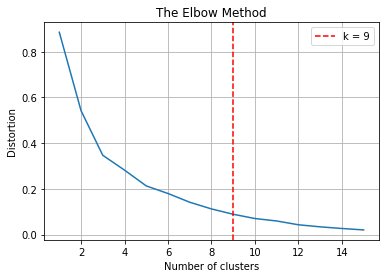

In [ ]:
X = gdf_estaciones[["latitud","longitud"]]
max_k = 15
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
k = 9

In [ ]:
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = gdf_estaciones[["latitud","longitud"]]
## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1
## add clustering info to the original dataset
gdf_estaciones[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
gdf_estaciones.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,cve_estac,nom_estac,longitud,latitud,id_station,geometry,cluster,centroids
0,ACO,Acolman,-98.912003,19.635501,ACO,POINT (-98.91200 19.63550),6,1
25988,AJU,Ajusco,-99.162611,19.154286,AJU,POINT (-99.16261 19.15429),2,0
48741,AJM,Ajusco Medio,-99.207744,19.272161,AJM,POINT (-99.20774 19.27216),2,1
69867,BJU,Benito Juárez,-99.159596,19.370464,BJU,POINT (-99.15960 19.37046),0,0
105578,CHO,Chalco,-98.886088,19.266948,CHO,POINT (-98.88609 19.26695),5,0


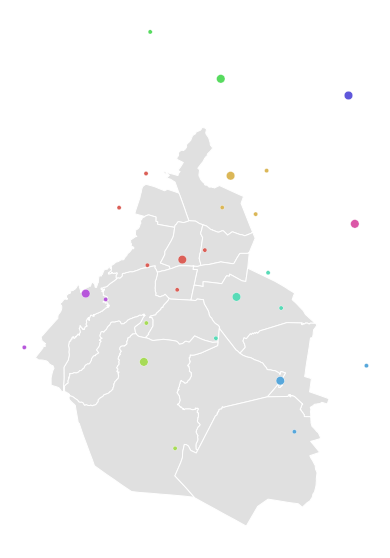

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
ax.axis('off')
gdf_cdmx.plot(ax=ax, color='#e0e0e0', edgecolor='white', figsize=(10,10))
sns.scatterplot(
    x="longitud",
    y="latitud",
    data=gdf_estaciones, 
    palette=sns.color_palette("hls",k),
    hue='cluster', size="centroids", size_order=[1,0],
    legend=False, ax=ax
)

In [ ]:
df_aire_daily.head(1)

,id_station,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var
0,ACO,2018-01-01,0.243478,2.0,12.782609,14.652174,14.652174,55.73913,1.608696,NaN,NaN,55.73913,11.6,199.391304,3.173913,928.29249


In [ ]:
gdf_estaciones.head(1)

,cve_estac,nom_estac,longitud,latitud,id_station,geometry,cluster,centroids
0,ACO,Acolman,-98.912003,19.635501,ACO,POINT (-98.91200 19.63550),6,1


In [ ]:
df_aire_clustered = df_aire_daily.merge(gdf_estaciones, on="id_station", how='inner')
df_aire_clustered = df_aire_clustered.groupby([df_aire_clustered.cluster, df_aire_clustered.date])[features].mean().reset_index()

In [ ]:
df_aire_clustered.head(2)

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var
0,0,2018-01-01,0.341621,5.354941,21.085771,26.458103,29.441700,61.780962,24.763505,46.634783,19.321739,52.458169,12.985310,275.528986,2.426877,508.824315
1,0,2018-01-02,0.576061,29.640909,33.087121,62.752273,22.231692,44.550505,5.090909,25.012121,21.006818,54.553030,13.014015,181.011995,1.306692,594.083106


In [ ]:
create_df_nan(df_aire_clustered, 'cluster')

19523
1.2639489994281925


,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,__aux,avg
cluster,,,,,,,,,,,,,,,,,
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000632,0.0,0.000057
1,0.0,0.017699,0.072061,0.001896,0.072061,0.000000,0.057522,0.020228,0.003161,0.057522,0.000000,0.000632,0.000000,0.000000,0.059418,0.0,0.032927
2,0.0,0.027866,0.003800,0.003800,0.003800,0.008233,0.033566,0.005700,0.006966,0.033566,0.000000,0.000000,0.000633,0.000633,0.036099,0.0,0.014969
3,0.0,0.103888,0.001912,0.001912,0.001912,0.005736,0.004461,0.003187,1.000000,1.000000,0.000000,0.000000,0.009560,0.009560,0.006373,0.0,0.195318
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000632,0.231985,0.000632,0.000000,0.266751,0.005057,0.000000,0.000000,0.000000,0.233249,0.0,0.067119
5,0.0,0.036709,0.094937,0.058861,0.094937,0.000633,0.176582,0.011392,0.824684,0.824684,0.000000,0.000000,0.000000,0.000000,0.179114,0.0,0.209321
6,0.0,0.250226,0.253839,0.253839,0.253839,0.200542,0.063234,0.297200,1.000000,1.000000,0.240289,0.016260,0.025294,0.025294,0.065041,0.0,0.358627
7,0.0,0.000000,0.037927,0.037927,0.037927,0.000000,0.024652,0.000000,0.075853,0.075853,0.000000,0.000000,0.000000,0.000000,0.025284,0.0,0.028675
8,0.0,0.075800,0.054937,0.054937,0.054937,0.042420,1.000000,0.095271,0.424200,1.000000,0.020167,0.020167,0.041725,0.041725,1.000000,0.0,0.356935


In [ ]:
df_aire_daily_summary = df_aire_clustered.groupby("date").mean().reset_index()
df_aire_daily_summary = df_aire_daily_summary.add_prefix('daily_')
df_aire_daily_summary["date"] = df_aire_daily_summary["daily_date"]
df_aire_daily_summary

,daily_date,daily_cluster,daily_CO,daily_NO,daily_NO2,daily_NOX,daily_O3,daily_PM10,daily_SO2,daily_PM2.5,daily_PMCO,daily_RH,daily_TMP,daily_WDR,daily_WSP,daily_PM10_var,date
0,2018-01-01,4.0,0.413723,4.855863,17.596487,22.449451,27.903345,67.449040,11.449568,47.051594,20.276087,56.726431,11.889028,201.897746,2.308059,1298.372229,2018-01-01
1,2018-01-02,4.0,0.449346,17.742508,22.954125,40.708586,24.331299,50.988366,3.272447,25.520480,23.194413,60.373948,11.652329,163.901024,1.543490,952.293834,2018-01-02
2,2018-01-03,4.0,0.530557,22.818159,29.699448,52.511459,29.133521,70.327936,7.740477,34.696468,35.769494,54.869254,13.313966,185.664577,1.792607,893.784348,2018-01-03
3,2018-01-04,4.0,0.517592,23.005093,33.430247,56.398611,29.361574,73.483532,15.950257,40.934484,32.530903,59.516053,12.283350,151.792093,1.587360,735.282024,2018-01-04
4,2018-01-05,4.0,0.533921,16.812529,32.456591,49.281769,33.324071,78.409597,5.658167,42.746399,38.586928,53.116942,14.517302,154.205811,1.689338,730.802267,2018-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,2022-04-27,4.0,0.216348,4.998371,12.904234,18.134975,35.353837,24.289615,1.235420,10.201190,12.523864,57.976263,15.470815,192.933227,2.282315,146.434540,2022-04-27
1578,2022-04-28,4.0,0.390747,12.591435,19.470129,32.307870,41.352932,31.989910,1.673319,15.465391,11.220328,57.864620,16.450124,184.167114,1.871183,292.650621,2022-04-28
1579,2022-04-29,4.0,0.409869,10.060568,20.035573,31.310652,46.315492,34.238202,1.288545,18.306850,13.343750,56.485934,17.656792,160.977502,1.856558,265.474710,2022-04-29
1580,2022-04-30,4.0,0.313071,6.349537,18.393827,25.832948,48.165895,44.588344,1.462037,23.951284,16.082828,47.478993,18.916979,175.426698,2.032423,174.070461,2022-04-30


In [ ]:
create_df_nan(df_aire_daily_summary, "daily_cluster") # Just grouping because... why not?

1
8.218277449046722e-05


,daily_date,daily_CO,daily_NO,daily_NO2,daily_NOX,daily_O3,daily_PM10,daily_SO2,daily_PM2.5,daily_PMCO,daily_RH,daily_TMP,daily_WDR,daily_WSP,daily_PM10_var,date,__aux,avg
daily_cluster,,,,,,,,,,,,,,,,,,
3.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3.857143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000986,0.0,0.0,0.000082
4.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [ ]:
df_aire_clustered_s = df_aire_clustered.merge(df_aire_daily_summary, on="date", how="left")
df_aire_clustered_s

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,...,daily_O3,daily_PM10,daily_SO2,daily_PM2.5,daily_PMCO,daily_RH,daily_TMP,daily_WDR,daily_WSP,daily_PM10_var
0,0,2018-01-01,0.341621,5.354941,21.085771,26.458103,29.441700,61.780962,24.763505,46.634783,...,27.903345,67.449040,11.449568,47.051594,20.276087,56.726431,11.889028,201.897746,2.308059,1298.372229
1,0,2018-01-02,0.576061,29.640909,33.087121,62.752273,22.231692,44.550505,5.090909,25.012121,...,24.331299,50.988366,3.272447,25.520480,23.194413,60.373948,11.652329,163.901024,1.543490,952.293834
2,0,2018-01-03,0.615833,34.652381,40.684524,75.279762,26.187500,65.009921,12.316468,36.572619,...,29.133521,70.327936,7.740477,34.696468,35.769494,54.869254,13.313966,185.664577,1.792607,893.784348
3,0,2018-01-04,0.640831,34.725000,46.038889,80.816667,23.763889,72.472222,33.571759,46.741667,...,29.361574,73.483532,15.950257,40.934484,32.530903,59.516053,12.283350,151.792093,1.587360,735.282024
4,0,2018-01-05,0.573737,23.072727,39.006061,62.080303,33.638258,67.153409,12.178030,39.697727,...,33.324071,78.409597,5.658167,42.746399,38.586928,53.116942,14.517302,154.205811,1.689338,730.802267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13596,8,2022-04-27,0.200000,4.666667,7.958333,12.666667,32.958333,NaN,1.083333,12.708333,...,35.353837,24.289615,1.235420,10.201190,12.523864,57.976263,15.470815,192.933227,2.282315,146.434540
13597,8,2022-04-28,0.408333,14.208333,11.958333,26.250000,41.458333,NaN,2.291667,20.708333,...,41.352932,31.989910,1.673319,15.465391,11.220328,57.864620,16.450124,184.167114,1.871183,292.650621
13598,8,2022-04-29,0.386957,9.434783,14.260870,23.695652,47.434783,NaN,1.608696,19.913043,...,46.315492,34.238202,1.288545,18.306850,13.343750,56.485934,17.656792,160.977502,1.856558,265.474710
13599,8,2022-04-30,0.258333,1.041667,13.375000,14.541667,53.250000,NaN,1.958333,22.875000,...,48.165895,44.588344,1.462037,23.951284,16.082828,47.478993,18.916979,175.426698,2.032423,174.070461


In [ ]:
for feature in features:
  df_aire_clustered_s[feature] = df_aire_clustered_s[feature].fillna(df_aire_clustered_s[f'daily_{feature}'])

In [ ]:
df_aire_clustered_s.head(2)

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,...,daily_O3,daily_PM10,daily_SO2,daily_PM2.5,daily_PMCO,daily_RH,daily_TMP,daily_WDR,daily_WSP,daily_PM10_var
0,0,2018-01-01,0.341621,5.354941,21.085771,26.458103,29.441700,61.780962,24.763505,46.634783,...,27.903345,67.449040,11.449568,47.051594,20.276087,56.726431,11.889028,201.897746,2.308059,1298.372229
1,0,2018-01-02,0.576061,29.640909,33.087121,62.752273,22.231692,44.550505,5.090909,25.012121,...,24.331299,50.988366,3.272447,25.520480,23.194413,60.373948,11.652329,163.901024,1.543490,952.293834


In [ ]:
daily_cols = [col for col in df_aire_clustered_s.columns if col.startswith("daily_")]
df_aire_clustered_s.drop(daily_cols, inplace=True, axis=1)
df_aire_clustered_s.columns

Index(['cluster', 'date', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2',
       'PM2.5', 'PMCO', 'RH', 'TMP', 'WDR', 'WSP', 'PM10_var'],
      dtype='object')

In [ ]:
df_aire_clustered_s.dropna(inplace=True)

In [ ]:
df_aire_clustered_s

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var
0,0,2018-01-01,0.341621,5.354941,21.085771,26.458103,29.441700,61.780962,24.763505,46.634783,19.321739,52.458169,12.985310,275.528986,2.426877,508.824315
1,0,2018-01-02,0.576061,29.640909,33.087121,62.752273,22.231692,44.550505,5.090909,25.012121,21.006818,54.553030,13.014015,181.011995,1.306692,594.083106
2,0,2018-01-03,0.615833,34.652381,40.684524,75.279762,26.187500,65.009921,12.316468,36.572619,31.557143,49.047619,14.669742,185.158730,1.570933,232.192564
3,0,2018-01-04,0.640831,34.725000,46.038889,80.816667,23.763889,72.472222,33.571759,46.741667,29.494444,55.414352,13.125231,147.268519,1.422454,357.724034
4,0,2018-01-05,0.573737,23.072727,39.006061,62.080303,33.638258,67.153409,12.178030,39.697727,32.259848,44.804293,16.619066,169.859848,1.569255,234.366288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13595,8,2022-04-26,0.275000,7.541667,10.625000,18.166667,25.708333,37.276773,1.583333,21.833333,17.508955,51.333333,17.175000,149.416667,3.212500,483.309910
13596,8,2022-04-27,0.200000,4.666667,7.958333,12.666667,32.958333,24.289615,1.083333,12.708333,12.523864,54.958333,16.858333,211.333333,2.300000,146.434540
13597,8,2022-04-28,0.408333,14.208333,11.958333,26.250000,41.458333,31.989910,2.291667,20.708333,11.220328,55.625000,18.612500,177.250000,1.983333,292.650621
13598,8,2022-04-29,0.386957,9.434783,14.260870,23.695652,47.434783,34.238202,1.608696,19.913043,13.343750,56.478261,18.908696,138.913043,1.878261,265.474710


In [ ]:
df_aire_clustered_s = df_aire_clustered_s.merge(gdf_estaciones[gdf_estaciones.centroids == 1][["longitud", "latitud", "cluster"]], on="cluster")
df_aire_clustered_s.head()

In [ ]:
df_aire_clustered_s.to_csv("pollution_cdmx.csv")
!ls

df_aire.csv  mapa_mexico  mapa_mexico.zip  pollution_cdmx.csv  sample_data


### Visualizaciones

- Explorar datos
- Verificar que no existan irregularidades

In [ ]:
import pandas as pd
from plotnine.data import mpg
from plotnine import ggplot, aes, geom_point, geom_bar, geom_boxplot, geom_hline, facet_grid, labs, geom_point, geom_col, stat_count, geom_histogram, stat_density, coord_flip
from plotnine import scale_x_continuous, scale_y_continuous, scale_colour_discrete, scale_x_reverse, scale_y_reverse, scale_color_manual, scale_color_brewer, scale_x_discrete, scale_fill_manual
from plotnine import theme_xkcd, theme_classic, theme_light, theme, element_blank
from plotnine import geom_text, position_stack

In [ ]:
df_aire_days = df_aire_days.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_aire_days.dtypes

CO       float64
NO       float64
NO2      float64
NOX      float64
O3       float64
PM10     float64
SO2      float64
PM2.5    float64
PMCO     float64
RH       float64
TMP      float64
WDR      float64
WSP      float64
hour      object
day        int64
month      int64
dtype: object

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


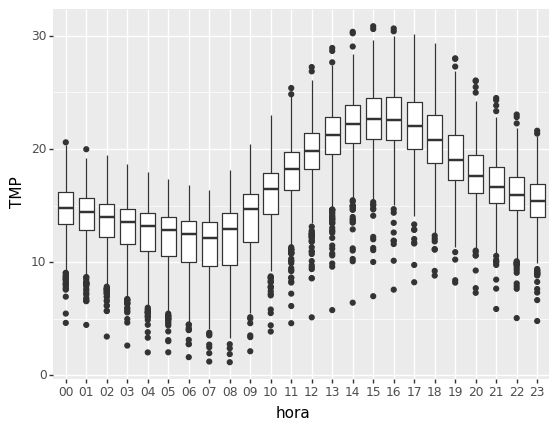

<ggplot: (8770078669037)>

In [ ]:
df_aire_days['hora'] = df_aire_days['hour'].map(lambda x : f"0{x}"[-2:])

ggplot(df_aire_days) + aes(x="hora", y="TMP") + geom_boxplot()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


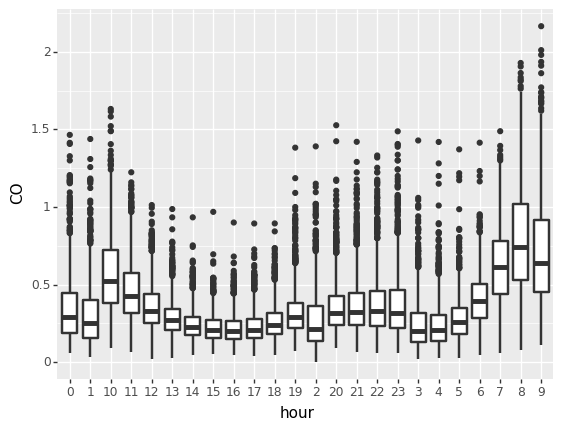

<ggplot: (8770114137897)>

In [ ]:
(ggplot(df_aire_days.sort_values(by="hour"), aes('hour'))
  + geom_boxplot(aes(y='CO'), size=1)
)

In [ ]:
df_aire_days['dia'] = df_aire_days.index.map(lambda x : x.strftime("%d/%m/%Y"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_aire_days

,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,hour,day,month,hora,dia
date,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,0.711111,3.777778,29.111111,32.888889,20.086957,99.125000,6.952381,66.142857,27.000000,54.541667,12.247826,206.608696,1.795652,1,1,1,1,01/01/2018
2018-01-01 02:00:00,0.655556,5.166667,26.611111,31.833333,20.304348,99.000000,8.714286,66.285714,24.900000,54.333333,11.808696,239.608696,1.860870,2,1,1,2,01/01/2018
2018-01-01 03:00:00,0.700000,7.277778,26.333333,33.555556,18.826087,97.500000,10.333333,70.428571,19.500000,55.625000,11.056522,226.565217,1.882609,3,1,1,3,01/01/2018
2018-01-01 04:00:00,0.616667,6.055556,26.055556,32.166667,17.521739,84.812500,15.904762,66.214286,17.500000,57.166667,10.352174,233.130435,1.673913,4,1,1,4,01/01/2018
2018-01-01 05:00:00,0.627778,7.166667,26.944444,33.944444,13.913043,83.250000,21.238095,61.785714,16.300000,62.000000,9.326087,249.000000,1.565217,5,1,1,5,01/01/2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28 20:00:00,0.317647,3.428571,23.111111,27.571429,26.526316,67.250000,0.750000,8.700000,42.428571,13.352941,18.882353,72.631579,2.968421,20,28,2,20,28/02/2022
2022-02-28 21:00:00,0.464706,5.642857,30.500000,37.714286,18.578947,71.083333,1.000000,9.100000,38.142857,19.117647,16.970588,85.736842,2.157895,21,28,2,21,28/02/2022
2022-02-28 22:00:00,0.623529,16.428571,35.500000,52.857143,11.947368,66.666667,1.187500,12.400000,31.714286,23.058824,15.400000,151.000000,1.752632,22,28,2,22,28/02/2022


In [ ]:
df_aire_export_days = df_aire_days.reset_index()

In [ ]:
df_aire_export_days.to_csv("df_aire_days.csv")

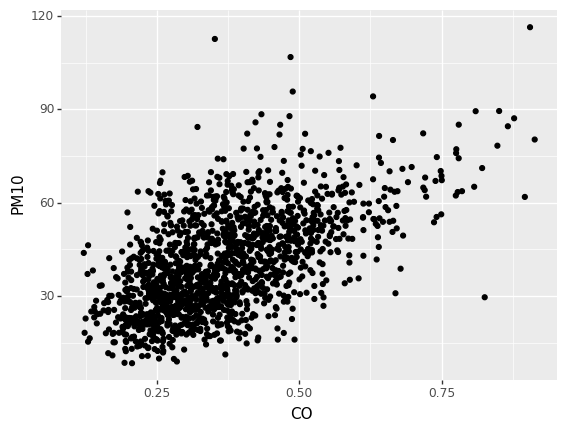

<ggplot: (8770077204133)>

In [ ]:
ggplot(df_aire_days.groupby("dia").mean()) + aes(x="CO", y="PM10") + geom_point()

In [ ]:
ggplot(df_aire_days.groupby("dia").mean()) + aes(x="CO", y="PM10") + geom_point()